# Spatial validation: Satellite vs Reconstructed sea ice concentration

## Figures 4 and S2 & S3 

Katie Brennan  
September 2020 

In [1]:
import sys,os,copy

In [2]:
import sys
import numpy as np
import xarray as xr

from scipy import stats
from scipy import signal

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [3]:
sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/instrumental_assimilation_experiments/')
import reanalysis_recons_utils as rrutils

sys.path.insert(1,'/home/disk/kalman2/mkb22/pyLMR/')
import LMR_utils as lmr

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_utils_kb/')
import Sice_utils as siutils  
import stats_utils as kbstats

sys.path.insert(1,'/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/')
import commonera_utils as ce_utils 

Loading information from datasets.yml
Loading information from grid_def.yml
Loading information from datasets.yml
Loading information from grid_def.yml


In [4]:
plt.rcParams['figure.dpi']=200

In [5]:
import importlib
# #importlib.reload(LMRlite)
# #importlib.reload(LMR_config)
# importlib.reload(LMRlite)
importlib.reload(ce_utils)

<module 'commonera_utils' from '/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/commonera_utils.py'>

In [6]:
def sub_arctic_plot(fig,ax,VAR1,LAT,LON,TITLE1,MAX1,colorbar=True,extent=True):
    var1, lon1 = add_cyclic_point(VAR1, coord=LON)
    new_lon2d, new_lat2d = np.meshgrid(lon1, LAT)
    if extent is True: 
        ax.set_extent([-150, 140, 50, 90], crs=ccrs.PlateCarree())
    ax.gridlines(linestyle='--')
    ax.add_feature(cfeature.LAND, facecolor=(1,1,1))
    cs = ax.pcolormesh(new_lon2d, new_lat2d, var1, 
                       vmin=-MAX1, vmax=MAX1, cmap=plt.cm.RdBu_r, 
                       transform=ccrs.PlateCarree())
    ax.coastlines(resolution='110m', linewidth=0.5)
    if colorbar is True:
        plt.colorbar(cs, ax=ax)
    ax.set_title(TITLE1)
    
    return cs

In [7]:
proj = dict(projection=ccrs.Stereographic(central_latitude=90,
                                          central_longitude=-45,
                                          true_scale_latitude=0.1))

In [8]:
def load_ccsm4_lm_regridded():
    ccsm4_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/CCSM4/CCSM4_last_millennium/'
    ccsm4_file = 'ccsm4_sic_sit_tas_20CRv2_850_1850_full.npz'

    ccsm4_lm = np.load(ccsm4_dir+ccsm4_file)

    ccsm4_truth_sic = ccsm4_lm['sic_ccsm4']
    ccsm4_truth_sit = ccsm4_lm['sit_ccsm4']
    ccsm4_truth_tas = ccsm4_lm['tas_ccsm4']
    ccsm4_truth_lat = ccsm4_lm['lat_ccsm4']
    ccsm4_truth_lon = ccsm4_lm['lon_ccsm4']
    
    return ccsm4_truth_tas, ccsm4_truth_sic, ccsm4_truth_sit, ccsm4_truth_lat, ccsm4_truth_lon

In [9]:
def calc_r_ce_spatial(true,recon):
    """
    Finds R, R^2 and CE values at every grid cell. 
    
    INPUTS:
    true: 2d field (time, lat*lon)
    recon: 2d field (time, lat*lon)
    
    OUTPUTS:
    r: correlation coefficient, 1d field (lat*lon)
    r2: correlation coefficient squared, 1d field (lat*lon)
    ce: coefficient of efficiency, 1d field (lat*lon)
    """
    if np.nanmax(recon)>2.0:
        if np.nanmax(true)>2.0:
            true = true
        else: 
            print('multiplying satellite data by 100%')
            true = true*100.0
    else: 
        if np.nanmax(true)>2.0:
            print('dividing satellite data by 100%')
            true = true/100.0
        else: 
            true = true
    
    r = np.zeros(true.shape[1])
    r2 = np.zeros(true.shape[1])
    ce = np.zeros(true.shape[1])

    for lalo in range(true.shape[1]):
        r[lalo],r2[lalo],_ = kbstats.corr_timeseries(true[:,lalo],recon[:,lalo])
        ce[lalo]= kbstats.coefficient_efficiency(true[:,lalo],recon[:,lalo])
    
    return r, r2, ce

In [10]:
[ccsm4_truth_tas, ccsm4_truth_sic, 
 ccsm4_truth_sit,
 ccsm4_truth_lat, ccsm4_truth_lon] = load_ccsm4_lm_regridded()

ccsm4_truth_time = np.arange(850,1851,1)

ccsm4_sic_mnstate = np.nanmean(ccsm4_truth_sic,axis=0)

## Load recon: 

In [11]:
output_dir_ccsm4 = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/ccsm4/'
output_file_ccsm4 = 'sic_ccsm4_anrecon_0_2000_pages2kv2_inf2_6_loc15000_iter0.pkl'

niter = 10

[sic_lalo_allit_ccsm4, tas_lalo_allit_ccsm4, sic_ens_var_allit_ccsm4, 
 nobs_allit_ccsm4, sia_ens_allit_ccsm4, sie_ens_allit_ccsm4, Ye_assim_allit_ccsm4, 
 Ye_assim_coords_allit_ccsm4, Xb_inflate_allit_ccsm4, recon_years_ccsm4, 
 proxy_assim_loc_allit_ccsm4] = ce_utils.load_recon_allit(output_dir_ccsm4,output_file_ccsm4,niter)

In [12]:
output_dir_mpi = '/home/disk/p/mkb22/nobackup/LMR_output/common_era_experiments/experiments/mpi/'
output_file_mpi = 'sic_mpi_anrecon_0_2000_pages2kv2_inf1_8_loc15000_iter0.pkl'

[sic_lalo_allit_mpi, tas_lalo_allit_mpi, sic_ens_var_allit_mpi, 
 nobs_allit_mpi, sia_ens_allit_mpi, sie_ens_allit_mpi, Ye_assim_allit_mpi, 
 Ye_assim_coords_allit_mpi, Xb_inflate_allit_mpi, recon_years_mpi, 
 proxy_assim_loc_allit_mpi] = ce_utils.load_recon_allit(output_dir_mpi,output_file_mpi,niter)

### Load sat data: 

In [13]:
sat_dir = '/home/disk/chaos/mkb22/Documents/SeaIceData/Observations/'
#sat_file = 'sic_mo_nh_v03r01_1979_2017_regrid_91_180.nc'
sat_file = 'sic_annual_nh_v03r01_1978_2019_regrid_91_180_091520.nc'

sat_ds = xr.open_dataset(sat_dir+sat_file)
# sat_sic = sat_ds.groupby('time.year').mean('time')
# it_sat = (sat_sic.year.values<2000)
# sat_sic_an = sat_sic.sic.values[it_sat,:,:]

sat_ds_tm = sat_ds.sel(year=slice(1979,1999))
sat_sic_merged = np.where(sat_ds_tm.goddard_merged_seaice_conc_annual.values>1.0,np.nan,
                          sat_ds_tm.goddard_merged_seaice_conc_annual.values)
sat_sic_nt = np.where(sat_ds_tm.goddard_bt_seaice_conc_annual.values>1.0,
                      np.nan,sat_ds_tm.goddard_bt_seaice_conc_annual.values)
sat_sic_bt = np.where(sat_ds_tm.goddard_nt_seaice_conc_annual.values>1.0,np.nan,
                      sat_ds_tm.goddard_nt_seaice_conc_annual.values)

sat_sic_merged[:,88:,:] = 1.0
sat_sic_nt[:,88:,:] = 1.0
sat_sic_bt[:,88:,:] = 1.0

sat_sic_merged_2d = np.reshape(sat_sic_merged,(sat_sic_merged.shape[0],
                                               sat_sic_merged.shape[1]*sat_sic_merged.shape[2]))
sat_sic_nt_2d = np.reshape(sat_sic_nt,(sat_sic_nt.shape[0],sat_sic_nt.shape[1]*sat_sic_nt.shape[2]))
sat_sic_bt_2d = np.reshape(sat_sic_bt,(sat_sic_bt.shape[0],sat_sic_bt.shape[1]*sat_sic_bt.shape[2]))

# sat_sic_an_2d = np.reshape(sat_sic_an,(sat_sic_an.shape[0],sat_sic_an.shape[1]*sat_sic_an.shape[2]))

In [14]:
sic_lalo_itmn_ccsm4 = np.nanmean(sic_lalo_allit_ccsm4[1979:,:,:],axis=3)
sic_lalo_itmn_ccsm4_2d = np.reshape(sic_lalo_itmn_ccsm4,
                                    (sic_lalo_itmn_ccsm4.shape[0],
                                     sic_lalo_itmn_ccsm4.shape[1]*sic_lalo_itmn_ccsm4.shape[2]))

sic_lalo_itmn_mpi = np.nanmean(sic_lalo_allit_mpi[1979:,:,:],axis=3)
sic_lalo_itmn_mpi_2d = np.reshape(sic_lalo_itmn_mpi,
                                    (sic_lalo_itmn_mpi.shape[0],
                                     sic_lalo_itmn_mpi.shape[1]*sic_lalo_itmn_mpi.shape[2]))

In [15]:
stip_merge = np.where(np.nanmean(sat_sic_merged,axis=0)*100>=95,np.nan,1.0)
stip_nt = np.where(np.nanmean(sat_sic_merged,axis=0)*100>=95,np.nan,1.0)
stip_bt = np.where(np.nanmean(sat_sic_merged,axis=0)*100>=95,np.nan,1.0)
stip_recon = np.where(sic_lalo_itmn_ccsm4>=95,1.0,0.0)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib

## CCSM4 Validation: Figure 4 

In [16]:
sic_lalo_itmn_ccsm4_anom_2d = sic_lalo_itmn_ccsm4_2d - np.nanmean(sic_lalo_itmn_ccsm4_2d,axis=0)
sat_sic_an_anom_2d = sat_sic_merged_2d - np.nanmean(sat_sic_merged_2d ,axis=0)

r_sic_anom2, r2_sic_anom2, ce_sic_anom2 = calc_r_ce_spatial(sat_sic_an_anom_2d,
                                                            sic_lalo_itmn_ccsm4_anom_2d)

r_sic_anom2_2d = np.reshape(r_sic_anom2,(91,180))
ce_sic_anom2_2d = np.reshape(ce_sic_anom2,(91,180))

recon_mn = np.nanmean(sic_lalo_itmn_ccsm4,axis=0)/100
recon_sat_mn = np.nanmean(sic_lalo_itmn_ccsm4,axis=0)/100
sat_mn = np.nanmean(sat_sic_merged,axis=0)

recon_mn_cut = np.where(recon_mn>=0.15,recon_mn,0.0)
sat_mn_cut = np.where(sat_mn>=0.15,sat_mn,0.0)

mn_diff_sat_period = np.where(sic_lalo_itmn_ccsm4[0,:,:]>0,(sat_mn_cut - recon_mn_cut)*100,0.0)
lm_sat_diff = sat_mn_cut*100 - np.where(ccsm4_sic_mnstate>=15.0,ccsm4_sic_mnstate,0.0)

lm_sat_diff_plot = np.where(sic_lalo_itmn_ccsm4[0,:,:]>0,lm_sat_diff,0.0)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:64: RuntimeWarning: invalid value encountered in double_scalars
  X_Y_corr = covariance(X,Y)/(X_stdev*Y_stdev)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:65: RuntimeWarning: invalid value encountered in double_scalars
  X_Y_reg = covariance(X,Y)/(X_stdev**2)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:177: RuntimeWarning: invalid value encountered in true_divide
  CE    = 1. - np.divide(numer,denom)


multiplying satellite data by 100%


/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:177: RuntimeWarning: divide by zero encountered in true_divide
  CE    = 1. - np.divide(numer,denom)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:80: RuntimeWarning: Mean of empty slice
  X_mean = np.nanmean(X,axis=0)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:176: RuntimeWarning: Mean of empty slice
  denom = np.nansum(np.power(ref-np.nanmean(ref,axis=0),2),axis=0)
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either

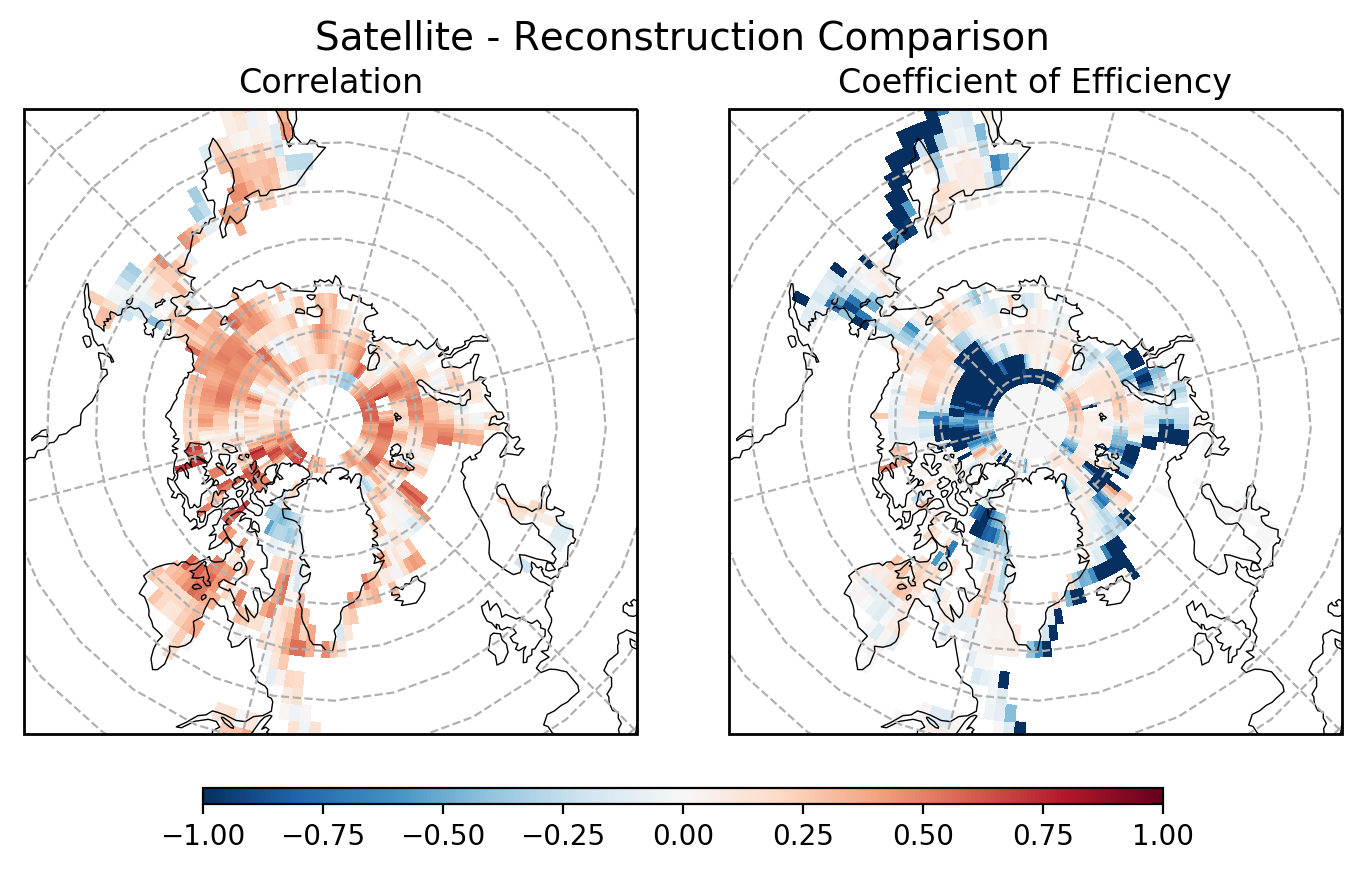

In [23]:
l2 = [-1.01,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.01]
lab = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1]

hold = np.where(recon_mn>0.15,1,0)
hold2 = np.where(sat_mn>=0.15,1,0)
ce_adj = np.where(hold*ce_sic_anom2_2d<-1.0,-1.0,ce_sic_anom2_2d)
r_adj = np.where(hold*r_sic_anom2_2d <-1.0,-1.0,r_sic_anom2_2d )

ce_adj[88:,:] = 0.0

fig,ax = plt.subplots(1,2, figsize=(8, 4), subplot_kw = proj)
ax = ax.flatten()

cs = sub_arctic_plot(fig,ax[0],r_sic_anom2_2d,sat_ds.lat.values,sat_ds.lon.values,
                     'Correlation',1, colorbar=False)
cs1 = sub_arctic_plot(fig,ax[1],ce_adj,sat_ds.lat.values,sat_ds.lon.values,
                      'Coefficient of Efficiency',1, colorbar=False)

position=fig.add_axes([0.15,0.0,0.6,0.02])
cb = plt.colorbar(cs, cax=position, orientation='horizontal')

fig.suptitle('Satellite - Reconstruction Comparison', fontsize=14, x=0.45)
plt.tight_layout(rect=(0,0.05,0.90,0.94))

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'sat_recon_ce_corr_spatial_validation.png'
#plt.savefig(savedir+savename, bbox_inches='tight')

## MPI Validation: Figure S3

In [17]:
sic_lalo_itmn_mpi_anom_2d = sic_lalo_itmn_mpi_2d - np.nanmean(sic_lalo_itmn_mpi_2d,axis=0)
sat_sic_an_anom_2d = sat_sic_merged_2d - np.nanmean(sat_sic_merged_2d ,axis=0)

r_sic_anom2, r2_sic_anom2, ce_sic_anom2 = calc_r_ce_spatial(sat_sic_an_anom_2d,
                                                            sic_lalo_itmn_mpi_anom_2d)

r_sic_anom2_mpi_2d = np.reshape(r_sic_anom2,(91,180))
ce_sic_anom2_mpi_2d = np.reshape(ce_sic_anom2,(91,180))

recon_mpi_mn = np.nanmean(sic_lalo_itmn_mpi,axis=0)/100
sat_mn = np.nanmean(sat_sic_merged,axis=0)

recon_mn_cut = np.where(recon_mpi_mn>=0.15,recon_mn,0.0)
sat_mn_cut = np.where(sat_mn>=0.15,sat_mn,0.0)

# mn_diff_sat_period = np.where(sic_lalo_itmn_mpi[0,:,:]>0,(sat_mn_cut - recon_mn_cut)*100,0.0)
# lm_sat_diff = sat_mn_cut*100 - np.where(mpi_sic_mnstate>=15.0,mpi_sic_mnstate,0.0)

# lm_sat_diff_plot = np.where(sic_lalo_itmn_mpi[0,:,:]>0,lm_sat_diff,0.0)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:64: RuntimeWarning: invalid value encountered in double_scalars
  X_Y_corr = covariance(X,Y)/(X_stdev*Y_stdev)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:65: RuntimeWarning: invalid value encountered in double_scalars
  X_Y_reg = covariance(X,Y)/(X_stdev**2)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:177: RuntimeWarning: invalid value encountered in true_divide
  CE    = 1. - np.divide(numer,denom)


multiplying satellite data by 100%


/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:177: RuntimeWarning: divide by zero encountered in true_divide
  CE    = 1. - np.divide(numer,denom)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:80: RuntimeWarning: Mean of empty slice
  X_mean = np.nanmean(X,axis=0)
/home/disk/p/mkb22/Documents/si_utils_kb/stats_utils.py:176: RuntimeWarning: Mean of empty slice
  denom = np.nansum(np.power(ref-np.nanmean(ref,axis=0),2),axis=0)
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either

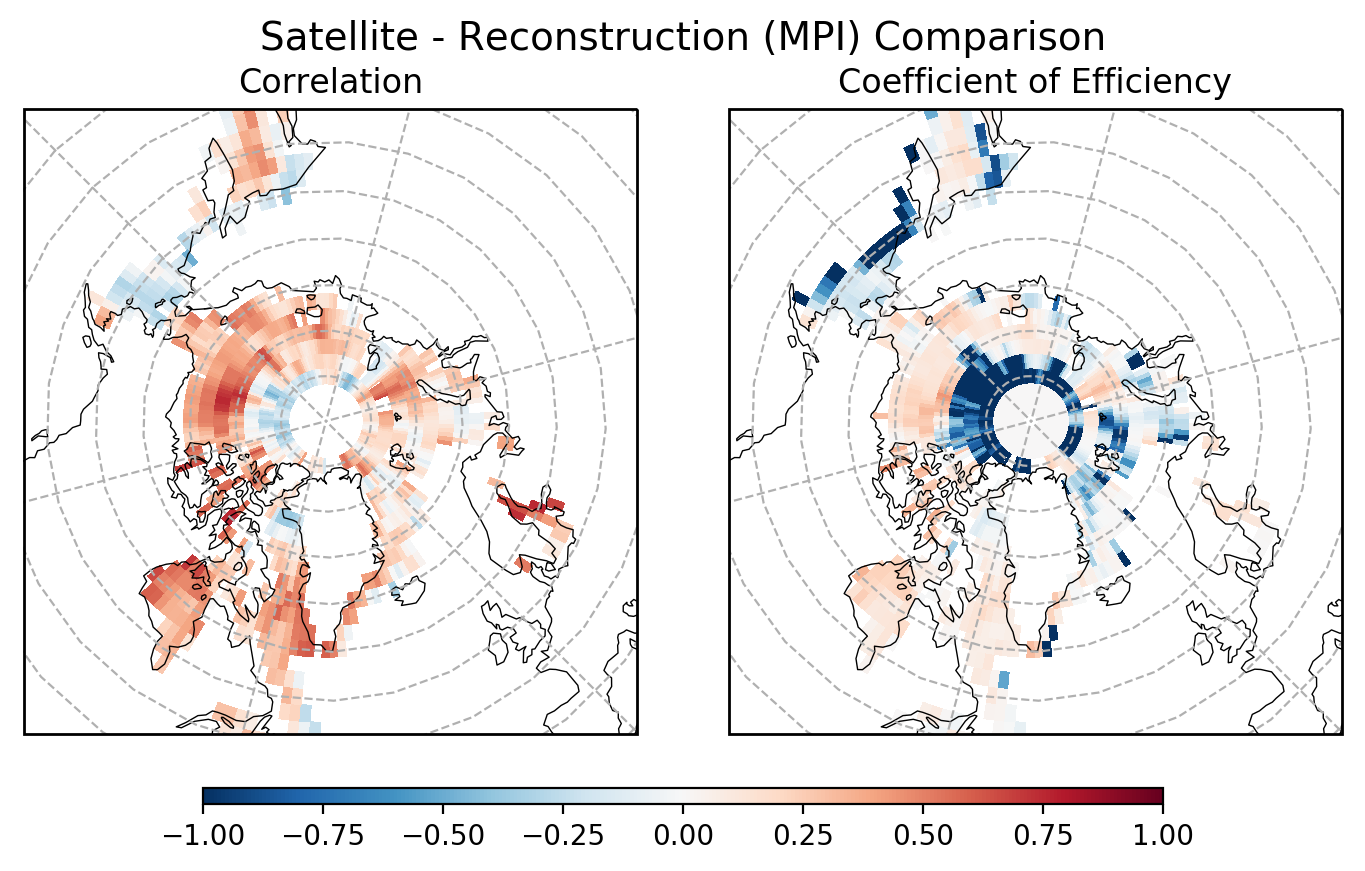

In [25]:
l2 = [-1.01,-0.9,-0.8,-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.01]
lab = [-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1]

hold = np.where(recon_mpi_mn>0.15,1,0)
hold2 = np.where(sat_mn>=0.15,1,0)
ce_adj = np.where(hold*ce_sic_anom2_mpi_2d<-1.0,-1.0,ce_sic_anom2_mpi_2d)
r_adj = np.where(hold*r_sic_anom2_mpi_2d <-1.0,-1.0,r_sic_anom2_mpi_2d )

ce_adj[88:,:] = 0.0

fig,ax = plt.subplots(1,2, figsize=(8, 4), subplot_kw = proj)
ax = ax.flatten()

cs = sub_arctic_plot(fig,ax[0],r_sic_anom2_mpi_2d,sat_ds.lat.values,sat_ds.lon.values,
                     'Correlation',1, colorbar=False)
cs1 = sub_arctic_plot(fig,ax[1],ce_adj,sat_ds.lat.values,sat_ds.lon.values,
                      'Coefficient of Efficiency',1, colorbar=False)

position=fig.add_axes([0.15,0.0,0.6,0.02])
cb = plt.colorbar(cs, cax=position, orientation='horizontal')

fig.suptitle('Satellite - Reconstruction (MPI) Comparison', fontsize=14, x=0.45)
plt.tight_layout(rect=(0,0.05,0.90,0.94))

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'sat_recon_ce_corr_spatial_validation_mpi.png'
#plt.savefig(savedir+savename, bbox_inches='tight')

## Mean state differences: Figure S2

In [18]:
mn_diff_sat_period = np.where(recon_mn>0.15,(sat_mn - recon_mn)*100,0.0)
lm_sat_diff = sat_mn*100 - ccsm4_sic_mnstate

lm_sat_diff = np.where(ccsm4_sic_mnstate>15,lm_sat_diff,0)
lm_sat_diff_plot = np.where(ccsm4_sic_mnstate>15,lm_sat_diff,np.nan)
mn_diff_sat_period_plot = np.where(np.abs(mn_diff_sat_period)<0.01,np.nan,mn_diff_sat_period)

diff = mn_diff_sat_period - lm_sat_diff
diff_plot = np.where(np.abs(diff)<0.01,np.nan,diff)

/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/home/disk/chaos/mkb22/anaconda2/envs/lmr_py3_xarray/lib/python3.6/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


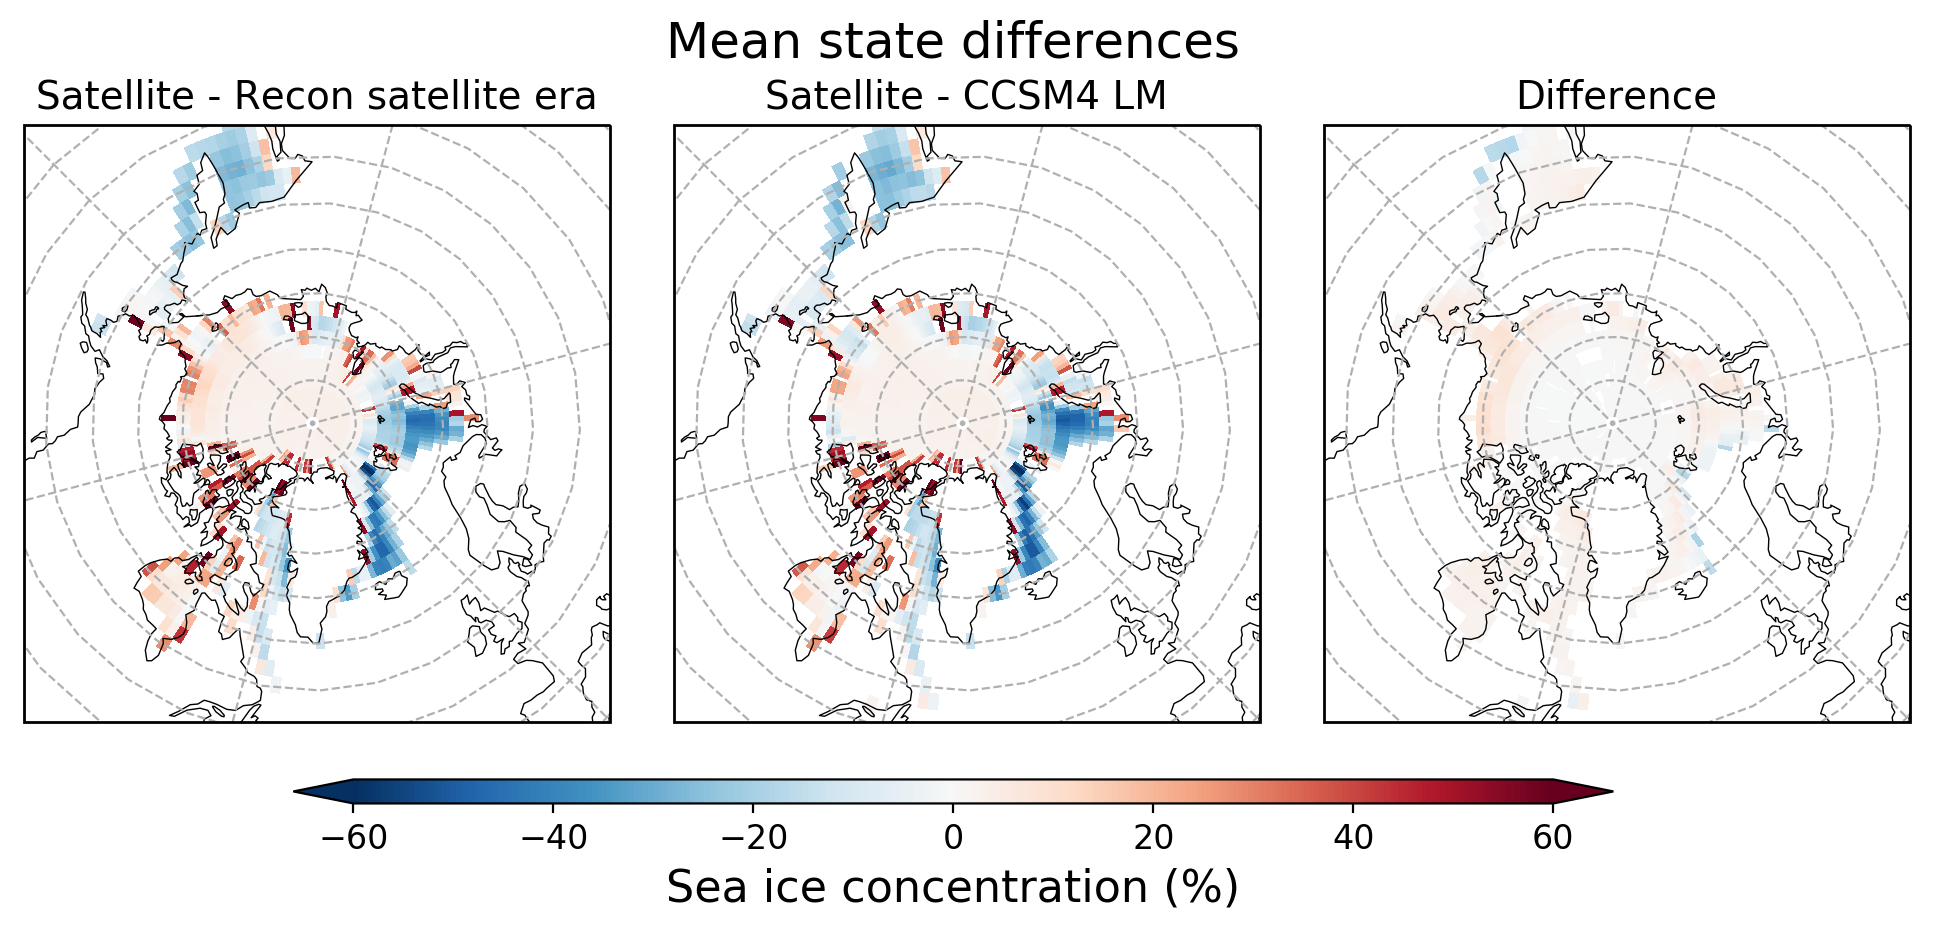

In [19]:
l2 = [-60.01,-50,-40,-30,-20,-10,10,20,30,40,50,60.01]
lab = [-60,-50,-40,-30,-20,-10,0,10,20,30,40,50,60]

fig,ax = plt.subplots(1,3, figsize=(11, 4), subplot_kw = proj)
ax = ax.flatten()

cs = sub_arctic_plot(fig,ax[0],mn_diff_sat_period_plot,sat_ds.lat.values,sat_ds.lon.values,
                     'Satellite - Reconstruction',60, colorbar=False)
cs1 = sub_arctic_plot(fig,ax[1],lm_sat_diff_plot,sat_ds.lat.values,sat_ds.lon.values,
                      'Satellite - Reconstruction',60, colorbar=False)
cs2 = sub_arctic_plot(fig,ax[2],diff_plot,sat_ds.lat.values,sat_ds.lon.values,
                      'Satellite - Reconstruction',60, colorbar=False)


position=fig.add_axes([0.15,-0.0,0.6,0.03])
cb = plt.colorbar(cs, cax=position,orientation='horizontal',extend='both')
cb.set_label('Sea ice concentration (%)',fontsize=16)
cb.ax.tick_params(labelsize=12)

ax[0].set_title('Satellite - Recon satellite era', fontsize=14)
ax[1].set_title('Satellite - CCSM4 LM', fontsize=14)
ax[2].set_title('Difference', fontsize=14)

fig.suptitle('Mean state differences', fontsize=18, x=0.45)
plt.tight_layout(rect=(0,0.05,0.90,0.90))

savedir = ('/home/disk/p/mkb22/Documents/si_analysis_kb/common_era_experiments/'+
           'analysis/figures/Brennan_Hakim_2020/')
savename = 'sat_recon_lm_mnstat_differences.png'
plt.savefig(savedir+savename,  bbox_inches='tight')